<a href="https://colab.research.google.com/github/StarKill53/Deep-Convolutional-Generative-Adversarial-Networks/blob/main/DCGANv2_Galaxies%26Coo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip '/content/gdrive/MyDrive/Star&Galaxies2.zip' > /dev/null

replace Star&Galaxies2/img/1073_PIA16853.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: none
replace Star&Galaxies2/img/139975main_image_feature_476_ys_full.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [ ]:
DATA_DIR = 'Star&Galaxies2'

In [ ]:
image_size = 64
batch_size = 10
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


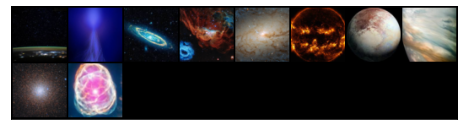

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([10, 3, 64, 64])


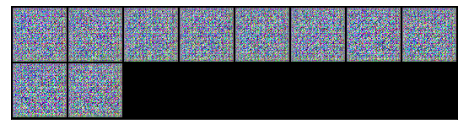

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


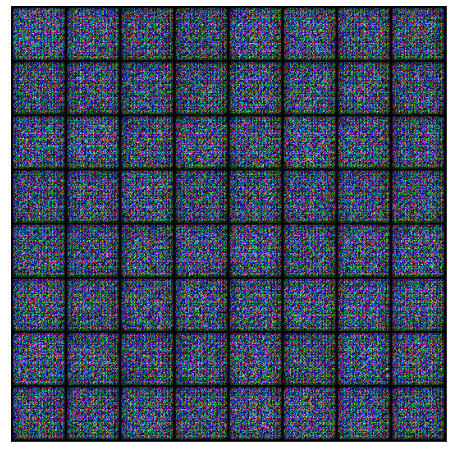

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr =  0.002
epochs = 200

In [ ]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/200], loss_g: 7.7940, loss_d: 1.5444, real_score: 0.4671, fake_score: 0.0017
Saving generated-images-0001.png



Epoch [2/200], loss_g: 3.1519, loss_d: 0.1805, real_score: 0.9781, fake_score: 0.1407
Saving generated-images-0002.png



Epoch [3/200], loss_g: 1.4488, loss_d: 0.6693, real_score: 0.9329, fake_score: 0.4384
Saving generated-images-0003.png



Epoch [4/200], loss_g: 2.9483, loss_d: 0.2008, real_score: 0.9182, fake_score: 0.1017
Saving generated-images-0004.png



Epoch [5/200], loss_g: 5.0045, loss_d: 0.1997, real_score: 0.9907, fake_score: 0.1523
Saving generated-images-0005.png



Epoch [6/200], loss_g: 3.4332, loss_d: 1.9329, real_score: 0.2561, fake_score: 0.1264
Saving generated-images-0006.png



Epoch [7/200], loss_g: 1.8887, loss_d: 1.2257, real_score: 0.6744, fake_score: 0.4769
Saving generated-images-0007.png



Epoch [8/200], loss_g: 1.6993, loss_d: 1.0846, real_score: 0.5723, fake_score: 0.3057
Saving generated-images-0008.png



Epoch [9/200], loss_g: 2.5457, loss_d: 1.5231, real_score: 0.8922, fake_score: 0.6495
Saving generated-images-0009.png



Epoch [10/200], loss_g: 0.9844, loss_d: 1.7643, real_score: 0.2643, fake_score: 0.1053
Saving generated-images-0010.png



Epoch [11/200], loss_g: 0.5613, loss_d: 2.1102, real_score: 0.2889, fake_score: 0.2681
Saving generated-images-0011.png



Epoch [12/200], loss_g: 1.4063, loss_d: 1.8778, real_score: 0.9360, fake_score: 0.7359
Saving generated-images-0012.png



Epoch [13/200], loss_g: 0.8322, loss_d: 1.7885, real_score: 0.2913, fake_score: 0.0867
Saving generated-images-0013.png



Epoch [14/200], loss_g: 1.8279, loss_d: 1.1867, real_score: 0.6390, fake_score: 0.4815
Saving generated-images-0014.png



Epoch [15/200], loss_g: 2.0410, loss_d: 0.7998, real_score: 0.6770, fake_score: 0.2733
Saving generated-images-0015.png



Epoch [16/200], loss_g: 1.7982, loss_d: 1.0884, real_score: 0.5746, fake_score: 0.3177
Saving generated-images-0016.png



Epoch [17/200], loss_g: 2.6073, loss_d: 1.4253, real_score: 0.7617, fake_score: 0.6407
Saving generated-images-0017.png



Epoch [18/200], loss_g: 1.1702, loss_d: 1.4611, real_score: 0.7367, fake_score: 0.5438
Saving generated-images-0018.png



Epoch [19/200], loss_g: 1.7521, loss_d: 1.5314, real_score: 0.5672, fake_score: 0.3348
Saving generated-images-0019.png



Epoch [20/200], loss_g: 1.1613, loss_d: 1.4605, real_score: 0.3983, fake_score: 0.2731
Saving generated-images-0020.png



Epoch [21/200], loss_g: 3.0749, loss_d: 2.2178, real_score: 0.6978, fake_score: 0.7859
Saving generated-images-0021.png



Epoch [22/200], loss_g: 1.1091, loss_d: 1.1948, real_score: 0.4173, fake_score: 0.2130
Saving generated-images-0022.png



Epoch [23/200], loss_g: 2.4622, loss_d: 0.9483, real_score: 0.7938, fake_score: 0.4369
Saving generated-images-0023.png



Epoch [24/200], loss_g: 1.4102, loss_d: 1.3190, real_score: 0.4826, fake_score: 0.3809
Saving generated-images-0024.png



Epoch [25/200], loss_g: 1.2946, loss_d: 1.1091, real_score: 0.6853, fake_score: 0.4519
Saving generated-images-0025.png



Epoch [26/200], loss_g: 1.8345, loss_d: 1.5051, real_score: 0.5148, fake_score: 0.3847
Saving generated-images-0026.png



Epoch [27/200], loss_g: 1.3474, loss_d: 2.2565, real_score: 0.1477, fake_score: 0.0929
Saving generated-images-0027.png



Epoch [28/200], loss_g: 0.7565, loss_d: 1.7698, real_score: 0.3184, fake_score: 0.2572
Saving generated-images-0028.png



Epoch [29/200], loss_g: 2.2684, loss_d: 1.4676, real_score: 0.4276, fake_score: 0.3397
Saving generated-images-0029.png



Epoch [30/200], loss_g: 3.6439, loss_d: 1.7972, real_score: 0.3858, fake_score: 0.3875
Saving generated-images-0030.png



Epoch [31/200], loss_g: 1.8852, loss_d: 1.3087, real_score: 0.4719, fake_score: 0.3252
Saving generated-images-0031.png



Epoch [32/200], loss_g: 2.5118, loss_d: 1.2013, real_score: 0.6591, fake_score: 0.4975
Saving generated-images-0032.png



Epoch [33/200], loss_g: 1.6078, loss_d: 1.8020, real_score: 0.3219, fake_score: 0.1902
Saving generated-images-0033.png



Epoch [34/200], loss_g: 2.3565, loss_d: 0.7804, real_score: 0.7650, fake_score: 0.3326
Saving generated-images-0034.png



Epoch [35/200], loss_g: 2.4243, loss_d: 1.2410, real_score: 0.6994, fake_score: 0.5158
Saving generated-images-0035.png



Epoch [36/200], loss_g: 0.5641, loss_d: 2.5598, real_score: 0.1428, fake_score: 0.0989
Saving generated-images-0036.png



Epoch [37/200], loss_g: 0.9568, loss_d: 1.4760, real_score: 0.7454, fake_score: 0.6156
Saving generated-images-0037.png



Epoch [38/200], loss_g: 1.2546, loss_d: 1.3811, real_score: 0.4954, fake_score: 0.4284
Saving generated-images-0038.png



Epoch [39/200], loss_g: 0.9944, loss_d: 1.7846, real_score: 0.3975, fake_score: 0.5230
Saving generated-images-0039.png



Epoch [40/200], loss_g: 1.4037, loss_d: 1.7901, real_score: 0.5929, fake_score: 0.6874
Saving generated-images-0040.png



Epoch [41/200], loss_g: 1.9962, loss_d: 2.0932, real_score: 0.1807, fake_score: 0.1404
Saving generated-images-0041.png



Epoch [42/200], loss_g: 1.4465, loss_d: 0.9941, real_score: 0.5545, fake_score: 0.2349
Saving generated-images-0042.png



Epoch [43/200], loss_g: 2.3785, loss_d: 1.4810, real_score: 0.5947, fake_score: 0.5666
Saving generated-images-0043.png



Epoch [44/200], loss_g: 0.9475, loss_d: 1.6531, real_score: 0.4792, fake_score: 0.4930
Saving generated-images-0044.png



Epoch [45/200], loss_g: 0.9216, loss_d: 1.0456, real_score: 0.6131, fake_score: 0.3759
Saving generated-images-0045.png



Epoch [46/200], loss_g: 1.2653, loss_d: 2.2303, real_score: 0.3261, fake_score: 0.4906
Saving generated-images-0046.png



Epoch [47/200], loss_g: 3.2309, loss_d: 1.2239, real_score: 0.6087, fake_score: 0.3430
Saving generated-images-0047.png



Epoch [48/200], loss_g: 1.0642, loss_d: 1.0885, real_score: 0.5998, fake_score: 0.4182
Saving generated-images-0048.png



Epoch [49/200], loss_g: 1.3534, loss_d: 1.1906, real_score: 0.5186, fake_score: 0.2889
Saving generated-images-0049.png



Epoch [50/200], loss_g: 1.1707, loss_d: 0.8954, real_score: 0.6767, fake_score: 0.3606
Saving generated-images-0050.png



Epoch [51/200], loss_g: 1.1200, loss_d: 1.0935, real_score: 0.4686, fake_score: 0.2396
Saving generated-images-0051.png



Epoch [52/200], loss_g: 2.1689, loss_d: 1.6006, real_score: 0.5941, fake_score: 0.5941
Saving generated-images-0052.png



Epoch [53/200], loss_g: 0.6791, loss_d: 1.2449, real_score: 0.7648, fake_score: 0.5775
Saving generated-images-0053.png



Epoch [54/200], loss_g: 0.7829, loss_d: 1.5575, real_score: 0.4449, fake_score: 0.4954
Saving generated-images-0054.png



Epoch [55/200], loss_g: 1.2647, loss_d: 1.9607, real_score: 0.3860, fake_score: 0.3731
Saving generated-images-0055.png



Epoch [56/200], loss_g: 1.0249, loss_d: 1.7140, real_score: 0.3955, fake_score: 0.2628
Saving generated-images-0056.png



Epoch [57/200], loss_g: 1.9096, loss_d: 1.2487, real_score: 0.7228, fake_score: 0.5484
Saving generated-images-0057.png



Epoch [58/200], loss_g: 1.0414, loss_d: 0.9431, real_score: 0.7052, fake_score: 0.4166
Saving generated-images-0058.png



Epoch [59/200], loss_g: 0.9164, loss_d: 0.8810, real_score: 0.7298, fake_score: 0.4047
Saving generated-images-0059.png



Epoch [60/200], loss_g: 1.5301, loss_d: 0.9894, real_score: 0.5972, fake_score: 0.2943
Saving generated-images-0060.png



Epoch [61/200], loss_g: 2.8120, loss_d: 1.5775, real_score: 0.5265, fake_score: 0.5493
Saving generated-images-0061.png



Epoch [62/200], loss_g: 0.8655, loss_d: 1.0322, real_score: 0.5898, fake_score: 0.3361
Saving generated-images-0062.png



Epoch [63/200], loss_g: 1.9202, loss_d: 2.9480, real_score: 0.8956, fake_score: 0.9226
Saving generated-images-0063.png



Epoch [64/200], loss_g: 1.2819, loss_d: 0.9457, real_score: 0.6066, fake_score: 0.2999
Saving generated-images-0064.png



Epoch [65/200], loss_g: 2.7314, loss_d: 2.5527, real_score: 0.4281, fake_score: 0.6878
Saving generated-images-0065.png



Epoch [66/200], loss_g: 1.1808, loss_d: 1.5538, real_score: 0.3146, fake_score: 0.1805
Saving generated-images-0066.png



Epoch [67/200], loss_g: 1.5875, loss_d: 2.6913, real_score: 0.6056, fake_score: 0.7954
Saving generated-images-0067.png



Epoch [68/200], loss_g: 1.4224, loss_d: 1.1723, real_score: 0.5699, fake_score: 0.3771
Saving generated-images-0068.png



Epoch [69/200], loss_g: 1.0088, loss_d: 1.0477, real_score: 0.5674, fake_score: 0.2923
Saving generated-images-0069.png



Epoch [70/200], loss_g: 0.8251, loss_d: 1.2754, real_score: 0.5965, fake_score: 0.4193
Saving generated-images-0070.png



Epoch [71/200], loss_g: 1.7964, loss_d: 1.0251, real_score: 0.7528, fake_score: 0.4784
Saving generated-images-0071.png



Epoch [72/200], loss_g: 0.8204, loss_d: 1.6136, real_score: 0.5744, fake_score: 0.5698
Saving generated-images-0072.png



Epoch [73/200], loss_g: 1.3828, loss_d: 1.5362, real_score: 0.6421, fake_score: 0.5771
Saving generated-images-0073.png



Epoch [74/200], loss_g: 2.1768, loss_d: 1.1230, real_score: 0.5129, fake_score: 0.2976
Saving generated-images-0074.png



Epoch [75/200], loss_g: 1.3054, loss_d: 0.8051, real_score: 0.6235, fake_score: 0.2400
Saving generated-images-0075.png



Epoch [76/200], loss_g: 1.5765, loss_d: 1.1379, real_score: 0.6462, fake_score: 0.4275
Saving generated-images-0076.png



Epoch [77/200], loss_g: 2.0207, loss_d: 1.5950, real_score: 0.5492, fake_score: 0.4857
Saving generated-images-0077.png



Epoch [78/200], loss_g: 1.2579, loss_d: 1.4934, real_score: 0.5654, fake_score: 0.4442
Saving generated-images-0078.png



Epoch [79/200], loss_g: 2.3537, loss_d: 1.0881, real_score: 0.7744, fake_score: 0.4641
Saving generated-images-0079.png



Epoch [80/200], loss_g: 1.6497, loss_d: 0.6861, real_score: 0.7113, fake_score: 0.2623
Saving generated-images-0080.png



Epoch [81/200], loss_g: 2.1014, loss_d: 1.1243, real_score: 0.8420, fake_score: 0.5204
Saving generated-images-0081.png



Epoch [82/200], loss_g: 1.9074, loss_d: 1.6877, real_score: 0.4283, fake_score: 0.2708
Saving generated-images-0082.png



Epoch [83/200], loss_g: 1.0132, loss_d: 1.1225, real_score: 0.5670, fake_score: 0.3212
Saving generated-images-0083.png



Epoch [84/200], loss_g: 2.7866, loss_d: 1.2794, real_score: 0.6510, fake_score: 0.4657
Saving generated-images-0084.png



Epoch [85/200], loss_g: 1.5395, loss_d: 0.8182, real_score: 0.7437, fake_score: 0.3482
Saving generated-images-0085.png



Epoch [86/200], loss_g: 0.9297, loss_d: 1.4582, real_score: 0.3604, fake_score: 0.1903
Saving generated-images-0086.png



Epoch [87/200], loss_g: 2.8848, loss_d: 0.7504, real_score: 0.7476, fake_score: 0.2758
Saving generated-images-0087.png



Epoch [88/200], loss_g: 2.9545, loss_d: 1.0166, real_score: 0.7761, fake_score: 0.4314
Saving generated-images-0088.png



Epoch [89/200], loss_g: 2.1025, loss_d: 1.3168, real_score: 0.6576, fake_score: 0.4368
Saving generated-images-0089.png



Epoch [90/200], loss_g: 2.3409, loss_d: 0.9689, real_score: 0.6773, fake_score: 0.3425
Saving generated-images-0090.png



Epoch [91/200], loss_g: 2.0686, loss_d: 1.3819, real_score: 0.4575, fake_score: 0.3033
Saving generated-images-0091.png



Epoch [92/200], loss_g: 1.6134, loss_d: 1.0158, real_score: 0.6683, fake_score: 0.3354
Saving generated-images-0092.png



Epoch [93/200], loss_g: 3.3314, loss_d: 1.8257, real_score: 0.3829, fake_score: 0.2121
Saving generated-images-0093.png



Epoch [94/200], loss_g: 2.4994, loss_d: 1.0017, real_score: 0.6110, fake_score: 0.2716
Saving generated-images-0094.png



Epoch [95/200], loss_g: 4.2684, loss_d: 1.3117, real_score: 0.3949, fake_score: 0.0736
Saving generated-images-0095.png



Epoch [96/200], loss_g: 1.8544, loss_d: 0.8056, real_score: 0.6754, fake_score: 0.2206
Saving generated-images-0096.png



Epoch [97/200], loss_g: 2.1985, loss_d: 0.8093, real_score: 0.7851, fake_score: 0.3762
Saving generated-images-0097.png



Epoch [98/200], loss_g: 2.9828, loss_d: 0.4257, real_score: 0.8717, fake_score: 0.2241
Saving generated-images-0098.png



Epoch [99/200], loss_g: 2.6526, loss_d: 0.8017, real_score: 0.8166, fake_score: 0.3678
Saving generated-images-0099.png



Epoch [100/200], loss_g: 2.4914, loss_d: 1.0929, real_score: 0.8132, fake_score: 0.3117
Saving generated-images-0100.png



Epoch [101/200], loss_g: 3.6345, loss_d: 1.2877, real_score: 0.9019, fake_score: 0.4942
Saving generated-images-0101.png



Epoch [102/200], loss_g: 3.1982, loss_d: 1.1908, real_score: 0.5169, fake_score: 0.1744
Saving generated-images-0102.png



Epoch [103/200], loss_g: 2.2145, loss_d: 0.7531, real_score: 0.7086, fake_score: 0.2785
Saving generated-images-0103.png



Epoch [104/200], loss_g: 2.3602, loss_d: 0.2930, real_score: 0.8849, fake_score: 0.1285
Saving generated-images-0104.png



Epoch [105/200], loss_g: 3.0103, loss_d: 0.4287, real_score: 0.7991, fake_score: 0.1590
Saving generated-images-0105.png



Epoch [106/200], loss_g: 3.1891, loss_d: 0.8174, real_score: 0.8569, fake_score: 0.3594
Saving generated-images-0106.png



Epoch [107/200], loss_g: 3.7852, loss_d: 0.2554, real_score: 0.8546, fake_score: 0.0762
Saving generated-images-0107.png



Epoch [108/200], loss_g: 3.9860, loss_d: 0.7180, real_score: 0.7185, fake_score: 0.0732
Saving generated-images-0108.png



Epoch [109/200], loss_g: 2.0953, loss_d: 0.7525, real_score: 0.6710, fake_score: 0.1742
Saving generated-images-0109.png



Epoch [110/200], loss_g: 3.3195, loss_d: 0.7881, real_score: 0.6846, fake_score: 0.1938
Saving generated-images-0110.png



Epoch [111/200], loss_g: 3.5727, loss_d: 0.6994, real_score: 0.6685, fake_score: 0.1834
Saving generated-images-0111.png



Epoch [112/200], loss_g: 2.9405, loss_d: 0.5032, real_score: 0.7620, fake_score: 0.1597
Saving generated-images-0112.png



Epoch [113/200], loss_g: 5.9055, loss_d: 0.4860, real_score: 0.9313, fake_score: 0.2652
Saving generated-images-0113.png



Epoch [114/200], loss_g: 3.8706, loss_d: 0.6796, real_score: 0.7531, fake_score: 0.1583
Saving generated-images-0114.png



Epoch [115/200], loss_g: 4.6377, loss_d: 0.5071, real_score: 0.6968, fake_score: 0.0578
Saving generated-images-0115.png



Epoch [116/200], loss_g: 5.8014, loss_d: 0.2091, real_score: 0.9644, fake_score: 0.1478
Saving generated-images-0116.png



Epoch [117/200], loss_g: 5.2368, loss_d: 0.2266, real_score: 0.9676, fake_score: 0.1355
Saving generated-images-0117.png



Epoch [118/200], loss_g: 5.3202, loss_d: 0.6595, real_score: 0.8797, fake_score: 0.3358
Saving generated-images-0118.png



Epoch [119/200], loss_g: 3.3342, loss_d: 0.5415, real_score: 0.8411, fake_score: 0.2316
Saving generated-images-0119.png



Epoch [120/200], loss_g: 3.3346, loss_d: 0.6427, real_score: 0.6901, fake_score: 0.1281
Saving generated-images-0120.png



Epoch [121/200], loss_g: 5.6440, loss_d: 1.2888, real_score: 0.6135, fake_score: 0.0313
Saving generated-images-0121.png



Epoch [122/200], loss_g: 3.0494, loss_d: 0.4930, real_score: 0.8355, fake_score: 0.2219
Saving generated-images-0122.png



Epoch [123/200], loss_g: 4.6832, loss_d: 0.4708, real_score: 0.7391, fake_score: 0.0600
Saving generated-images-0123.png



Epoch [124/200], loss_g: 3.2181, loss_d: 0.7804, real_score: 0.7090, fake_score: 0.0159
Saving generated-images-0124.png



Epoch [125/200], loss_g: 4.4568, loss_d: 0.4795, real_score: 0.7130, fake_score: 0.0706
Saving generated-images-0125.png



Epoch [126/200], loss_g: 3.4063, loss_d: 0.6996, real_score: 0.8479, fake_score: 0.1241
Saving generated-images-0126.png



Epoch [127/200], loss_g: 3.5552, loss_d: 0.3583, real_score: 0.9100, fake_score: 0.1645
Saving generated-images-0127.png



Epoch [128/200], loss_g: 5.7832, loss_d: 0.6240, real_score: 0.7463, fake_score: 0.1489
Saving generated-images-0128.png



Epoch [129/200], loss_g: 9.7514, loss_d: 0.9153, real_score: 0.9332, fake_score: 0.4849
Saving generated-images-0129.png



Epoch [130/200], loss_g: 6.7315, loss_d: 1.2790, real_score: 0.9706, fake_score: 0.6291
Saving generated-images-0130.png



Epoch [131/200], loss_g: 4.6923, loss_d: 0.1825, real_score: 0.8841, fake_score: 0.0382
Saving generated-images-0131.png



Epoch [132/200], loss_g: 6.4691, loss_d: 0.9095, real_score: 0.9803, fake_score: 0.4084
Saving generated-images-0132.png



Epoch [133/200], loss_g: 2.7611, loss_d: 1.3654, real_score: 0.5810, fake_score: 0.1006
Saving generated-images-0133.png



Epoch [134/200], loss_g: 6.0088, loss_d: 0.8470, real_score: 0.9585, fake_score: 0.4143
Saving generated-images-0134.png



Epoch [135/200], loss_g: 5.5201, loss_d: 0.3178, real_score: 0.9779, fake_score: 0.2277
Saving generated-images-0135.png



Epoch [136/200], loss_g: 6.4405, loss_d: 0.5384, real_score: 0.9291, fake_score: 0.2096
Saving generated-images-0136.png



Epoch [137/200], loss_g: 6.1582, loss_d: 0.0576, real_score: 0.9873, fake_score: 0.0422
Saving generated-images-0137.png



Epoch [138/200], loss_g: 6.4515, loss_d: 0.3101, real_score: 0.9931, fake_score: 0.2313
Saving generated-images-0138.png



Epoch [139/200], loss_g: 6.6643, loss_d: 0.0284, real_score: 0.9781, fake_score: 0.0057
Saving generated-images-0139.png



Epoch [140/200], loss_g: 7.1262, loss_d: 0.0775, real_score: 0.9569, fake_score: 0.0288
Saving generated-images-0140.png



Epoch [141/200], loss_g: 5.5499, loss_d: 0.0879, real_score: 0.9657, fake_score: 0.0483
Saving generated-images-0141.png



Epoch [142/200], loss_g: 7.7537, loss_d: 0.6327, real_score: 0.7657, fake_score: 0.0077
Saving generated-images-0142.png



Epoch [143/200], loss_g: 4.6764, loss_d: 0.2667, real_score: 0.9252, fake_score: 0.1247
Saving generated-images-0143.png



Epoch [144/200], loss_g: 6.3940, loss_d: 0.4248, real_score: 0.9673, fake_score: 0.2396
Saving generated-images-0144.png



Epoch [145/200], loss_g: 5.4062, loss_d: 0.1731, real_score: 0.9628, fake_score: 0.1132
Saving generated-images-0145.png



Epoch [146/200], loss_g: 6.1538, loss_d: 0.2652, real_score: 0.8730, fake_score: 0.0908
Saving generated-images-0146.png



Epoch [147/200], loss_g: 5.8707, loss_d: 0.1389, real_score: 0.9064, fake_score: 0.0249
Saving generated-images-0147.png



Epoch [148/200], loss_g: 6.8390, loss_d: 0.4691, real_score: 0.8125, fake_score: 0.0716
Saving generated-images-0148.png



Epoch [149/200], loss_g: 4.1987, loss_d: 0.5796, real_score: 0.6834, fake_score: 0.0050
Saving generated-images-0149.png



Epoch [150/200], loss_g: 9.0665, loss_d: 0.4629, real_score: 0.9177, fake_score: 0.1977
Saving generated-images-0150.png



Epoch [151/200], loss_g: 6.2112, loss_d: 0.1419, real_score: 0.9605, fake_score: 0.0700
Saving generated-images-0151.png



Epoch [152/200], loss_g: 6.1539, loss_d: 0.5432, real_score: 0.7190, fake_score: 0.0060
Saving generated-images-0152.png



Epoch [153/200], loss_g: 10.4621, loss_d: 1.4244, real_score: 0.4416, fake_score: 0.0001
Saving generated-images-0153.png



Epoch [154/200], loss_g: 7.9212, loss_d: 0.4084, real_score: 0.9500, fake_score: 0.2166
Saving generated-images-0154.png



Epoch [155/200], loss_g: 6.2789, loss_d: 0.2899, real_score: 0.8022, fake_score: 0.0065
Saving generated-images-0155.png



Epoch [156/200], loss_g: 8.8043, loss_d: 0.2949, real_score: 0.9954, fake_score: 0.2144
Saving generated-images-0156.png



Epoch [157/200], loss_g: 5.5453, loss_d: 0.3851, real_score: 0.9538, fake_score: 0.1763
Saving generated-images-0157.png



Epoch [158/200], loss_g: 3.5727, loss_d: 0.5877, real_score: 0.7956, fake_score: 0.0719
Saving generated-images-0158.png



Epoch [159/200], loss_g: 3.8657, loss_d: 0.3924, real_score: 0.8159, fake_score: 0.0424
Saving generated-images-0159.png



Epoch [160/200], loss_g: 7.5069, loss_d: 0.3403, real_score: 0.9843, fake_score: 0.1757
Saving generated-images-0160.png



Epoch [161/200], loss_g: 5.1287, loss_d: 0.2481, real_score: 0.9963, fake_score: 0.1939
Saving generated-images-0161.png



Epoch [162/200], loss_g: 7.6850, loss_d: 0.1361, real_score: 0.9825, fake_score: 0.0933
Saving generated-images-0162.png



Epoch [163/200], loss_g: 9.4456, loss_d: 0.5938, real_score: 0.9848, fake_score: 0.2387
Saving generated-images-0163.png



Epoch [164/200], loss_g: 5.6240, loss_d: 0.0607, real_score: 0.9944, fake_score: 0.0503
Saving generated-images-0164.png



Epoch [165/200], loss_g: 6.3855, loss_d: 0.2535, real_score: 0.9966, fake_score: 0.1849
Saving generated-images-0165.png



Epoch [166/200], loss_g: 7.6312, loss_d: 0.1564, real_score: 0.9974, fake_score: 0.1104
Saving generated-images-0166.png



Epoch [167/200], loss_g: 7.1526, loss_d: 0.0760, real_score: 0.9437, fake_score: 0.0143
Saving generated-images-0167.png



Epoch [168/200], loss_g: 6.8816, loss_d: 0.2435, real_score: 0.9153, fake_score: 0.0649
Saving generated-images-0168.png



Epoch [169/200], loss_g: 9.3079, loss_d: 0.0859, real_score: 0.9382, fake_score: 0.0065
Saving generated-images-0169.png



Epoch [170/200], loss_g: 4.5703, loss_d: 0.0436, real_score: 0.9981, fake_score: 0.0399
Saving generated-images-0170.png



Epoch [171/200], loss_g: 9.0019, loss_d: 0.8806, real_score: 0.9040, fake_score: 0.3383
Saving generated-images-0171.png



Epoch [172/200], loss_g: 6.4650, loss_d: 0.0637, real_score: 0.9517, fake_score: 0.0026
Saving generated-images-0172.png



Epoch [173/200], loss_g: 3.7353, loss_d: 0.1566, real_score: 0.9162, fake_score: 0.0367
Saving generated-images-0173.png



Epoch [174/200], loss_g: 6.7236, loss_d: 0.0380, real_score: 0.9698, fake_score: 0.0055
Saving generated-images-0174.png



Epoch [175/200], loss_g: 5.6355, loss_d: 0.2821, real_score: 0.8253, fake_score: 0.0072
Saving generated-images-0175.png



Epoch [176/200], loss_g: 9.4713, loss_d: 0.0100, real_score: 0.9941, fake_score: 0.0041
Saving generated-images-0176.png



Epoch [177/200], loss_g: 6.2332, loss_d: 0.0299, real_score: 0.9883, fake_score: 0.0167
Saving generated-images-0177.png



Epoch [178/200], loss_g: 6.9578, loss_d: 0.0946, real_score: 0.9839, fake_score: 0.0687
Saving generated-images-0178.png



Epoch [179/200], loss_g: 6.4078, loss_d: 0.1808, real_score: 0.9926, fake_score: 0.1372
Saving generated-images-0179.png



Epoch [180/200], loss_g: 3.9279, loss_d: 0.3697, real_score: 0.7590, fake_score: 0.0114
Saving generated-images-0180.png



Epoch [181/200], loss_g: 7.3808, loss_d: 0.1404, real_score: 0.9661, fake_score: 0.0794
Saving generated-images-0181.png



Epoch [182/200], loss_g: 6.6570, loss_d: 0.0648, real_score: 0.9878, fake_score: 0.0448
Saving generated-images-0182.png



Epoch [183/200], loss_g: 3.1464, loss_d: 0.4356, real_score: 0.9858, fake_score: 0.1480
Saving generated-images-0183.png



Epoch [184/200], loss_g: 8.2057, loss_d: 0.0281, real_score: 0.9926, fake_score: 0.0200
Saving generated-images-0184.png



Epoch [185/200], loss_g: 4.6345, loss_d: 0.2710, real_score: 0.8266, fake_score: 0.0428
Saving generated-images-0185.png



Epoch [186/200], loss_g: 6.9128, loss_d: 0.0256, real_score: 0.9937, fake_score: 0.0179
Saving generated-images-0186.png



Epoch [187/200], loss_g: 7.6153, loss_d: 0.3664, real_score: 0.9504, fake_score: 0.1234
Saving generated-images-0187.png



Epoch [188/200], loss_g: 4.1626, loss_d: 0.5699, real_score: 0.7688, fake_score: 0.0080
Saving generated-images-0188.png



Epoch [189/200], loss_g: 6.4989, loss_d: 0.0931, real_score: 0.9294, fake_score: 0.0051
Saving generated-images-0189.png



Epoch [190/200], loss_g: 5.1515, loss_d: 0.5887, real_score: 0.7539, fake_score: 0.0115
Saving generated-images-0190.png



Epoch [191/200], loss_g: 7.7726, loss_d: 0.0137, real_score: 0.9982, fake_score: 0.0115
Saving generated-images-0191.png



Epoch [192/200], loss_g: 7.9353, loss_d: 0.3345, real_score: 0.9912, fake_score: 0.1832
Saving generated-images-0192.png



Epoch [193/200], loss_g: 7.6606, loss_d: 0.8386, real_score: 0.8325, fake_score: 0.1255
Saving generated-images-0193.png



Epoch [194/200], loss_g: 7.1702, loss_d: 0.3926, real_score: 0.8309, fake_score: 0.0081
Saving generated-images-0194.png



Epoch [195/200], loss_g: 7.8212, loss_d: 0.1064, real_score: 0.9691, fake_score: 0.0643
Saving generated-images-0195.png



Epoch [196/200], loss_g: 8.9583, loss_d: 0.2019, real_score: 0.9045, fake_score: 0.0014
Saving generated-images-0196.png



Epoch [197/200], loss_g: 7.5627, loss_d: 0.0235, real_score: 0.9989, fake_score: 0.0218
Saving generated-images-0197.png



Epoch [198/200], loss_g: 5.3926, loss_d: 0.0639, real_score: 0.9993, fake_score: 0.0580
Saving generated-images-0198.png



Epoch [199/200], loss_g: 7.6325, loss_d: 0.2052, real_score: 0.9309, fake_score: 0.0839
Saving generated-images-0199.png



Epoch [200/200], loss_g: 10.1825, loss_d: 0.2383, real_score: 0.8703, fake_score: 0.0106
Saving generated-images-0200.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
from IPython.display import Image

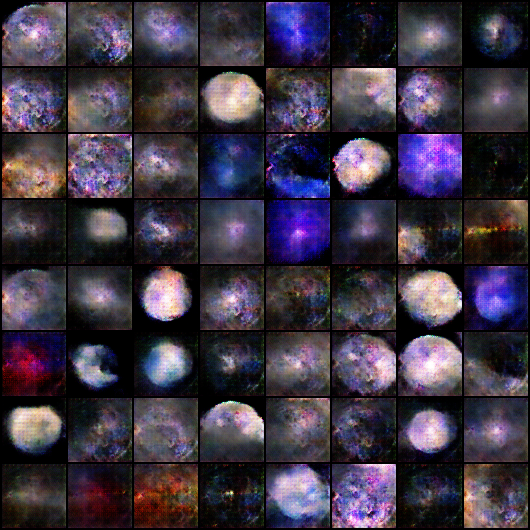

In [ ]:
Image('./generated/generated-images-0200.png')

In [ ]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

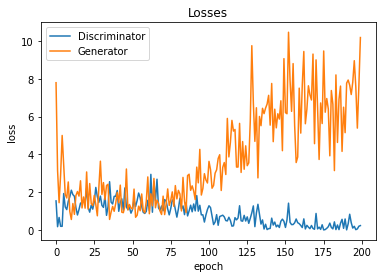

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

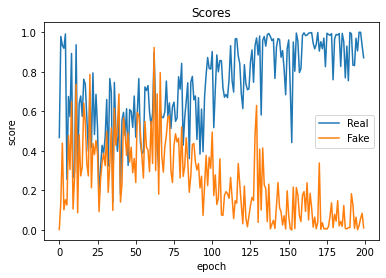

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');